## Example of metric calculation using moving object metrics.

The inputs needed here (the obsfile) can be calculated using the code demonstrated in the [ExampleMoObs](./ExampleMoObs.ipynb) notebook. 

Here, I'm working through how those observations can be read back into the code and metric values (such as discovery chances and then completeness) can be calculated. 

There are definitely some things to be improved upon; if the observation generation stopped at the point of generating interpolations, for example, and the moving object slicer read those interpolations back in, together with the the simdata, it could generate the actual observations on the fly (when using the camera footprint, this would add non-insignificant overhead, so it might actually be nice to be able to do either/both). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from moSlicer import MoSlicer
import moMetrics as MoMetrics
from moSecondaryMetrics import MoCompletenessMetric, IntegrateOverHMetric
import moPlots as moPlots
import moMetricBundle as mmb
import lsst.sims.maf.plots as plots

In [2]:
# Set up MoSlicer.  We use the moving object slicer to read the observation data from disk.
orbitfile = 'test.des'
obsfile = 'test_out.txt'
runName = 'enigma_1189'
metadata = '8 NEOs'

In [3]:
mos = MoSlicer(orbitfile, obsfile, Hrange=np.arange(15, 25, 0.5))
print mos.slicePoints['H']
mos.allObs.tail(10)

[ 15.   15.5  16.   16.5  17.   17.5  18.   18.5  19.   19.5  20.   20.5
  21.   21.5  22.   22.5  23.   23.5  24.   24.5]


,objId,delta,ra,dec,magV,time,dradt,ddecdt,phase,solarelon,...,rotSkyPos,filter,finSeeing,fiveSigmaDepth,visitExpTime,solarElong,magFilter,dmagColor,dmagTrail,dmagDetect
2431,8,0.323380,176.456130,-18.861696,20.153360,52268.320679,1.437831,-0.998385,72.632124,89.079095,...,2.345846,i,0.635707,24.073750,30,87.227643,19.862008,-0.291352,0.559607,0.970495
2432,8,0.323292,176.478613,-18.876455,20.153062,52268.335453,1.436049,-0.997843,72.646830,89.068001,...,2.284969,i,0.619369,24.129871,30,87.242023,19.861710,-0.291352,0.570135,0.993211
2433,8,0.317814,177.999706,-19.833496,20.136777,52269.292945,1.498154,-1.019283,73.647167,88.288804,...,2.889092,z,0.951961,22.726123,30,88.166315,19.838701,-0.298076,0.414101,0.660775
2434,8,0.317748,178.018006,-19.845215,20.136575,52269.304439,1.496557,-1.018850,73.659214,88.279475,...,2.936336,z,0.922078,22.674212,30,88.177523,19.838499,-0.298076,0.425558,0.684708
2435,8,0.301925,183.267775,-22.969688,20.102907,52272.326691,1.677787,-1.065021,77.131032,85.452159,...,1.822959,y,0.703703,21.580819,30,85.684510,19.800344,-0.302563,0.570235,0.993427
2436,8,0.297207,185.183103,-24.036033,20.098701,52273.333388,1.742610,-1.074349,78.395997,84.382589,...,2.790610,y,0.698627,21.590743,30,84.202100,19.796137,-0.302563,0.585914,1.027294
2437,8,0.297205,185.183955,-24.036511,20.098699,52273.333835,1.742592,-1.074306,78.396557,84.382116,...,2.847067,y,0.707097,21.575894,30,83.622789,19.796135,-0.302563,0.580773,1.016186
2438,8,0.297200,185.185657,-24.037467,20.098695,52273.334728,1.742556,-1.074220,78.397674,84.381171,...,2.846882,y,0.705913,21.577961,30,83.623660,19.796132,-0.302563,0.581470,1.017692
2439,8,0.297198,185.186509,-24.037946,20.098694,52273.335175,1.742539,-1.074176,78.398233,84.380698,...,2.789728,y,0.696484,21.594524,30,84.203812,19.796130,-0.302563,0.587194,1.030060
2440,8,0.275893,198.669897,-30.389473,20.167817,52279.364037,2.152566,-1.019919,87.054152,76.673629,...,3.049051,y,0.637395,21.543566,30,77.179873,19.865253,-0.302563,0.692914,1.258876


In [4]:
mos.orbits.tail()

,H,M,a,argPeri,e,epoch,g,inc,node,objId,q,tPeri
4,20,5874.569717,0.251116,43.240574,0.763736,49353.16,0.15,1.330878,349.850231,4,0.442902,48603.137197
5,20,445.924828,0.696023,61.550945,0.299100,49353.16,0.15,64.006284,94.372124,5,0.904203,49090.445232
6,20,1307.509197,0.528869,290.866822,0.503057,49353.16,0.15,23.059935,191.223806,6,0.794920,48842.943433
7,20,4490.707335,0.364161,98.212633,0.712798,49353.16,0.15,2.523589,74.996555,7,0.623735,48351.908052
8,20,667.476892,0.320158,39.981806,0.449921,49353.16,0.15,5.856124,211.448230,8,0.464204,49230.480840


In [5]:
# Set up an example metric bundle.
metric = MoMetrics.NObsMetric()
slicer = mos
pandasConstraint = None
plotDict = {'nxbins':20, 'nybins':20}
nobs = mmb.MoMetricBundle(metric, slicer, pandasConstraint, 
                          runName=runName, metadata=metadata, plotDict=plotDict)

In [6]:
# Calculate completeness. First we must calculate "DiscoveryChances". 
# Set up an example metric bundle.
metric = MoMetrics.DiscoveryChancesMetric()
slicer = mos
pandasConstraint = None
discovery = mmb.MoMetricBundle(metric, slicer, pandasConstraint, 
                               runName=runName, metadata=metadata, plotDict=plotDict)

In [7]:
# try a different kind of metric, looking at chances of finding activity
metric = MoMetrics.ActivityOverTimeMetric(window=6*30.)
slicer = mos
pandasConstraint = None
activity6month = mmb.MoMetricBundle(metric, slicer, pandasConstraint, 
                               runName=runName, metadata=metadata, plotDict=plotDict)

Calculated all metrics.
Plotted all metrics.


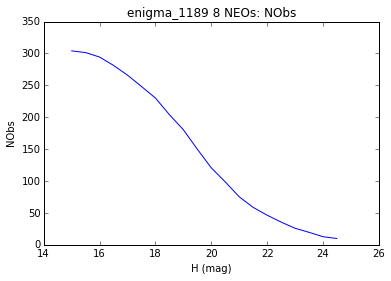

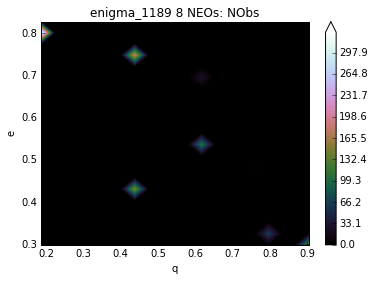

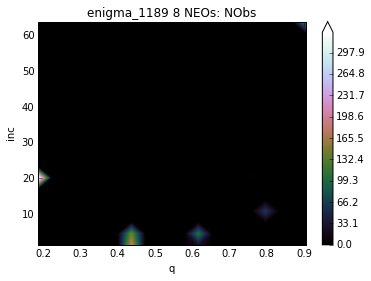

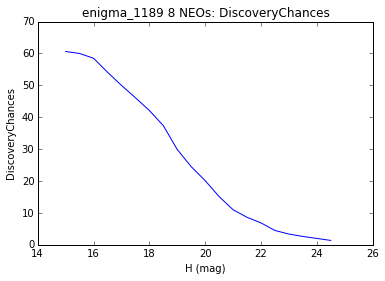

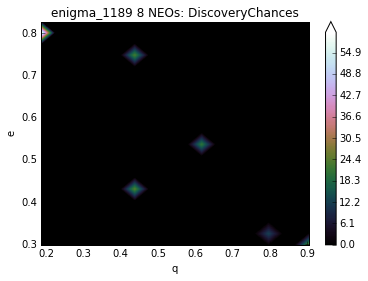

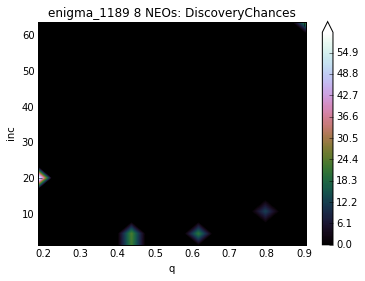

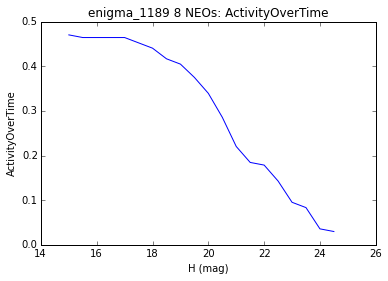

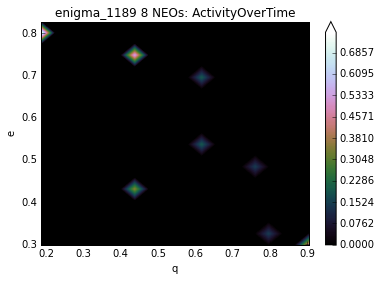

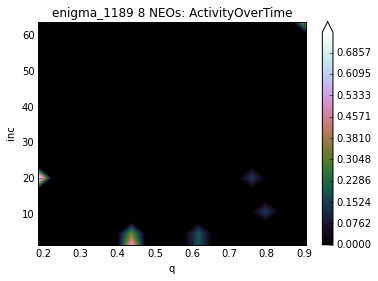

In [8]:
bdict = {'nobs':nobs, 'discovery':discovery, 'activity':activity6month}
bg = mmb.MoMetricBundleGroup(bdict)
bg.runAll()
bg.plotAll()

1

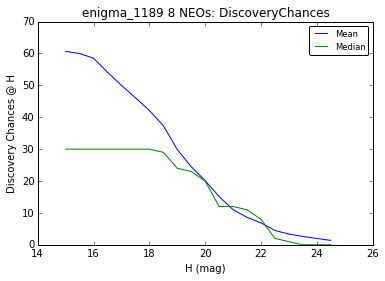

In [9]:
ph = plots.PlotHandler()
ph.setMetricBundles([discovery, discovery])
ph.setPlotDicts([{'npReduce':np.mean, 'color':'b', 'label':'Mean'}, 
                 {'npReduce':np.median, 'color':'g', 'label':'Median'}])
ph.plot(plotFunc=moPlots.MetricVsH(), plotDicts={'ylabel':'Discovery Chances @ H'})

In [10]:
# Then calculate 'completeness' as function of H, as a secondary metric.
completeness = discovery.runSecondaryMetric(MoCompletenessMetric())

{'MetricVsH': 1}

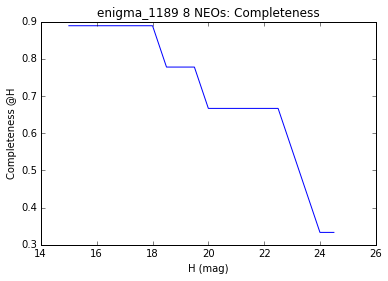

In [14]:
completeness.plot()

{'MetricVsH': 1}

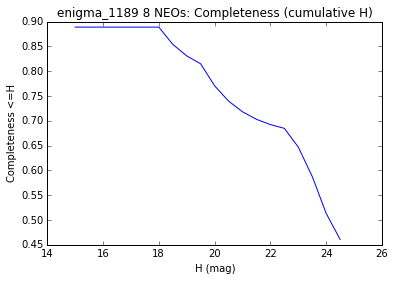

In [15]:
# And we can make an 'integrated over H distribution' version. 
completenessInt = completeness.runSecondaryMetric(IntegrateOverHMetric())
completenessInt.plot()

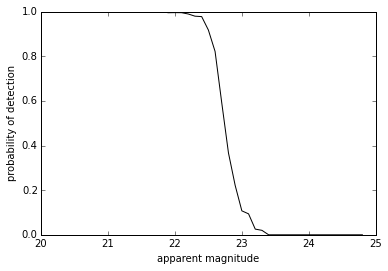

In [13]:
### side note.. illustrating detection probability curve (50% at m5)
# this probability curve is used if snrLimit is NOT set (otherwise it's just a cutoff at snrLimit)
metric = MoMetrics.BaseMoMetric()
# Check what 'visibility' looks like. 
nobjs = 10000
appMag = np.random.rand(nobjs) * 5.0 + 20.0
magLimit = 22.8
vis = metric._calcVis(appMag, magLimit)
bins = np.arange(appMag.min(), appMag.max(), 0.1)
vn, b = np.histogram(appMag[vis], bins=bins)
n, b = np.histogram(appMag, bins=bins)
plt.plot(b[:-1], vn / n.astype(float), 'k-')
plt.xlabel('apparent magnitude')
plt.ylabel('probability of detection')